In [1]:
import MDAnalysis as md
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis.leaflet import LeafletFinder
from scipy import optimize
from MDAnalysis.transformations.fit import fit_rot_trans

In [2]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [3]:
def get_princ (u):
    ND = u.select_atoms('all')
    I = ND.moment_of_inertia()
    e1,e2,e3 = ND.principal_axes()
    return e1,e2,e3

In [4]:
def align (u):
    e1,e2,e3 = get_princ(u)
    R1 = rotation_matrix_from_vectors(e1, [1,0,0])
    u.select_atoms('all').positions = np.dot(u.select_atoms('all').positions, R1) 

    e1,e2,e3 = get_princ(u)
    R2 = rotation_matrix_from_vectors(e2, [0,1,0])
    u.select_atoms('all').positions = np.dot(u.select_atoms('all').positions, R2) 

    e1,e2,e3 = get_princ(u)
    R3 = rotation_matrix_from_vectors(e3, [0,0,1])
    u.select_atoms('all').positions = np.dot(u.select_atoms('all').positions, R3) 
    return u

In [5]:
ref1 = md.Universe('GRO/1D1_69_v1_nowat.gro')
ref2 = md.Universe('GRO/1E3D1_134_v1_nowat.gro')
ref3 = md.Universe('GRO/2N2_302_v1_nowat.gro')
u1 = md.Universe('GRO/1D1_69_v1_nowat.gro', ('XTC/1D1_69_v1_nowat_fit.xtc', 'XTC/1D1_69_v2_nowat_fit.xtc', 'XTC/1D1_69_v3_nowat_fit.xtc'))
u2 = md.Universe('GRO/1E3D1_134_v1_nowat.gro', ('XTC/1E3D1_134_v1_nowat_fit.xtc', 'XTC/1E3D1_134_v2_nowat_fit.xtc', 'XTC/1E3D1_134_v3_nowat_fit.xtc'))
u3 = md.Universe('GRO/2N2_302_v1_nowat.gro', ('XTC/2N2_302_v1_nowat_fit.xtc', 'XTC/2N2_302_v2_nowat_fit.xtc', 'XTC/2N2_302_v3_nowat_fit.xtc'))

/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/au447022/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [7]:
U = [u1,u2,u3]
N = [n1,n2,n3]

In [8]:
def func (x, z0, a1, a2, b11, b12, b22):
    return z0 + a1*x[:,0] + a2*x[:,1] + b11*x[:,0]**2 + b12*x[:,0]*x[:,1] + b22*x[:,1]**2

In [9]:
systems = ['1D1_69','1E3D1_134','2N2_302']

In [10]:
def get_kappas (u):
    memb = u.select_atoms('name PO4')
    coors = memb.positions

    popt, pcov = optimize.curve_fit(func, coors[:,:2], coors[:,2], p0=[1,1,1,0,0,0])
    z0, a1, a2, b11, b12, b22 = popt
    B = np.zeros([2,2])
    B[0,0] = b11*2
    B[0,1] = b12
    B[1,0] = b12
    B[1,1] = b22*2

    eig_val, eig_vec = np.linalg.eig(B)
    return eig_val

In [11]:
def get_kappa (u, stride=100):
    nframes = len(u.trajectory[::stride])
    kappas = np.zeros([2,nframes])

    for idx, ts in enumerate(u.trajectory[::stride]):
        kappas[:,idx] = get_kappas(u)
    return kappas

In [12]:
K = []
for idx, u in enumerate(U):
    u = align(u)
    K.append(get_kappa(u))

In [13]:
K_mean = [ np.average(i, axis=0) for i in K ]

([<matplotlib.axis.XTick at 0x7fe2295e49d0>,
 <a list of 3 Text xticklabel objects>)

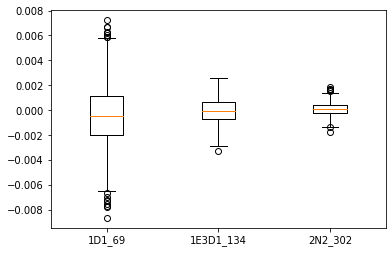

In [14]:
plt.boxplot(K_mean)
plt.xticks([1,2,3], systems)

In [15]:
K_gaus = [ k[0,:] * k[1,:] for k in K]

([<matplotlib.axis.XTick at 0x7fe229705e90>,
 <a list of 3 Text xticklabel objects>)

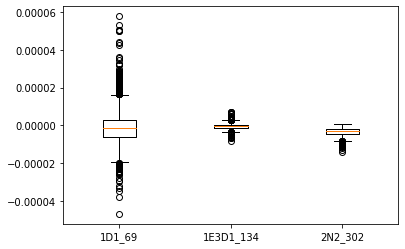

In [16]:
plt.boxplot(K_gaus)
plt.xticks([1,2,3], systems)

In [17]:
systemsn = ['NW9_58', 'NW11_73', 'NW13_151']

In [ ]:
Kn = []
for idx, n in enumerate(N):
    n = align(n)
    Kn.append(get_kappa(n))

In [ ]:
Kn_mean = [ np.average(i, axis=0) for i in Kn ]

In [ ]:
plt.boxplot(Kn_mean)
plt.xticks([1,2,3], systemsn)

In [ ]:
Kn_gaus = [ k[0,:] * k[1,:] for k in Kn]

In [ ]:
plt.boxplot(Kn_gaus)
plt.xticks([1,2,3], systemsn)

In [ ]:
for i in range(3):
    np.savetxt('{0:s}_kappas.txt'.format(systemsn[i]), Kn[i])
    np.savetxt('{0:s}_kappas.txt'.format(systems[i]), K[i])